<font face="Arial" color="darkgreen" size=10>Functional Data Analysis</font>

## <font face="Garamond" color="blue" size=8>Generalized Additive Models</font>

Main Idea:

We want

$$\large \mathbb{E}(y_i|x_i)\overset{\Delta}{=}\beta_0+f_1(x_{i1})+f_2(x_{i2})+...+f_p(x_{ip})$$

By comparison, a linear model is

$$\large \mathbb{E}(y_i|x_i)\overset{\Delta}{=}\beta_0+\beta_1\cdot x_{i1}+\beta_2\cdot x_{i2}+...+\beta_p\cdot x_{ip}$$

We consider a regularized maximum likelihood approach for the generalized additive model

$$\large
y_i = c +\sum\limits_{j=1}^{p}f_j(x_i^{(j)}) + \epsilon_i
$$

and for standardization we assume

$$\large
\sum\limits_{i=1}^{n}f_j(x_i^{(j)})=0
$$

For classificaiton problems we can use:

$$\large
g\left(\mathbb{E}(y_i|x_i)\right) = c +\sum\limits_{j=1}^{p}f_j(x_i^{(j)})
$$

The sparsity-smoothness penalty:

$$\large
J(f_i) = \lambda_1\sqrt{\|f_j\|^2_n+\lambda_2I^2(f_j)}
$$

where the following term is designed to control the rapid accelerations/decelerations.

$$\large
I^2(f_j)=\int(f''_j(x))^2dx \,\,\, \text{and}\,\,\,\|f\|^2_n=\frac{1}{n}\sum\limits_{i=1}^{n}f_i^2.
$$

The objective function is

$$\large
\left \|y-\sum\limits_{j=1}^{p}f_j\right\|_n^2 + \sum\limits_{j=1}^{p}J(f_j).
$$

and this is to minimize over a suitable class of functions $\mathcal{F}.$

## Setup

In [1]:
%config InlineBackend.figure_format = 'retina'
#import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 120

In [2]:
# general imports
import numpy as np
import pandas as pd
from math import ceil
from scipy import linalg
import csaps as cs
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error as mse, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,train_test_split as tts
from sklearn.datasets import make_spd_matrix
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')

## Cubic Splines

**What we need:**

- we need the tools, the building blocks for constructing any *nonlinearity* we want.
- we need a good validation mechanism.
- we need an efficient implementation of such tools in programming languages such as R and Python.

The main idea is to use third degree polynomial functions, such as

$$
s_i(x)=a_i(x-x_i)^3+b_i(x-x_i)^2+c_i(x-x_i)+d_i
$$

for $i=1,2,...,K-1$ and $x_i$ are the *knots* of the same feature. It is quite obvious that we have:


$$
s'_i(x) = 3a_i(x-x_i)^2+2b_i(x-x_i)+c_i
$$

and
$$
s''_i(x)=6a_i(x-x_i)+2b_i
$$


So we create

$$
S(x)=
\begin{cases}
s_1(x) &\text{if}& x_1\leq x < x_2 \\
s_2(x) &\text{if}& x_2\leq x < x_3 \\
...\\
s_n(x) &\text{if}& x_{n-1}\leq x < x_n
\end{cases}
$$

We generally want the following *properties* to hold:

1. $S(x)$ is continuous on $[x_1,x_n].$
2. $S'(x)$ is continuous on $[x_1,x_n].$
3. $S''(x)$ is continuous on $[x_1,x_n].$


## Generalized Additive Modeling

The assumption is that

$$
y_i = \sum\limits_{j=1}^{p}S_j(x_{ij}) +\text{noise}
$$

and of course, ideally, the mean of the noise should be 0; here $p$ is the number of features.

So we get

$$
\mathbb{E}(y_i|x_i) =  \sum\limits_{j=1}^{p}S_j(x_{ij})$$

<font color='blue'>
In this way we can reduce the nonlinear problem to a multiple linear one, however the tradeoff is that we have many more weigths to determine !
</font>

This is the reson we need very good methods of regularization and variable selection.


## Model Complexity

Let's assume that we have N knots. For each feature we fit N cubic splines. This means that we subdivide the range of each feature into N eaqually spaced intervals. ON each such interval you have a cubic polynomial. For the same feature the cubic polynomials connect smoothly at the knots.

Model Complexity: we determine 4 coefficients for each cubic. We have N knots for each feature so in the end we have 4*N*p coefficients (weights) to determine.

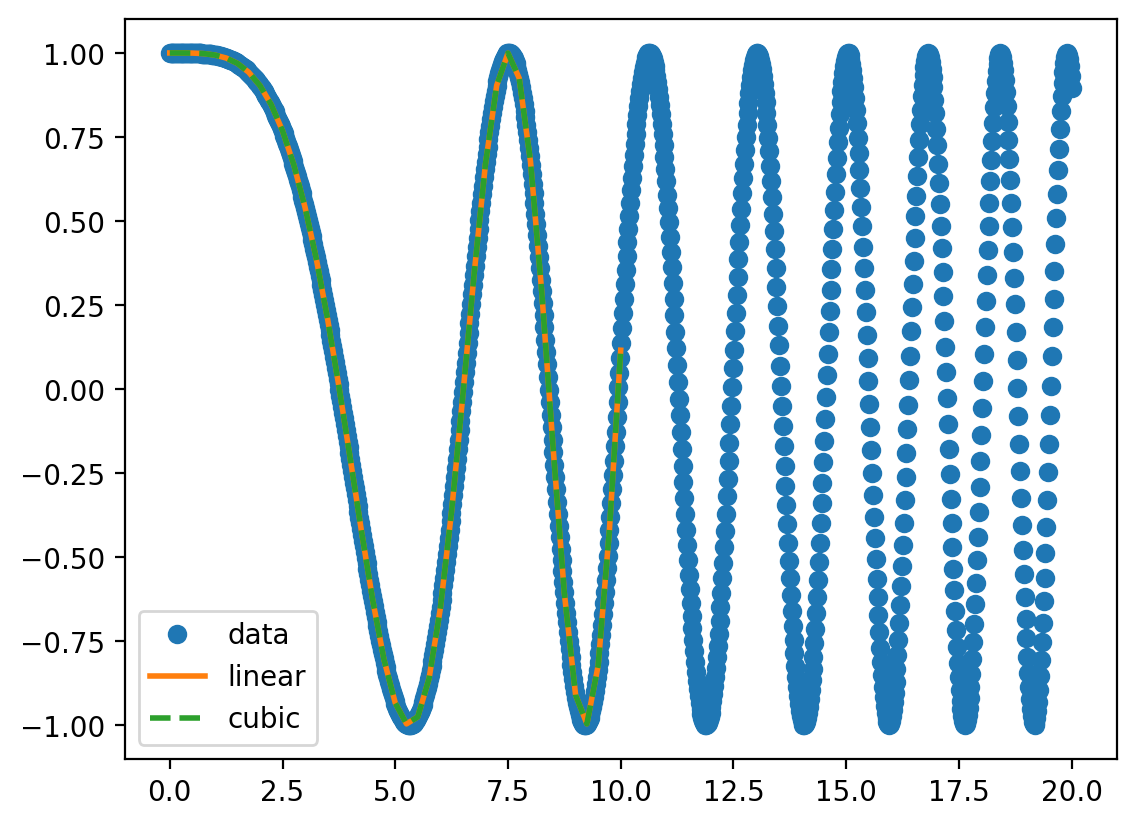

In [5]:
x = np.linspace(0, 20, num=1000, endpoint=True)
# here the groundtruth y is a nonlinear function of x
y = np.cos(-x**2/9.0)
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

xnew = np.linspace(0, 10, num=41, endpoint=True)
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--',lw=2)
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

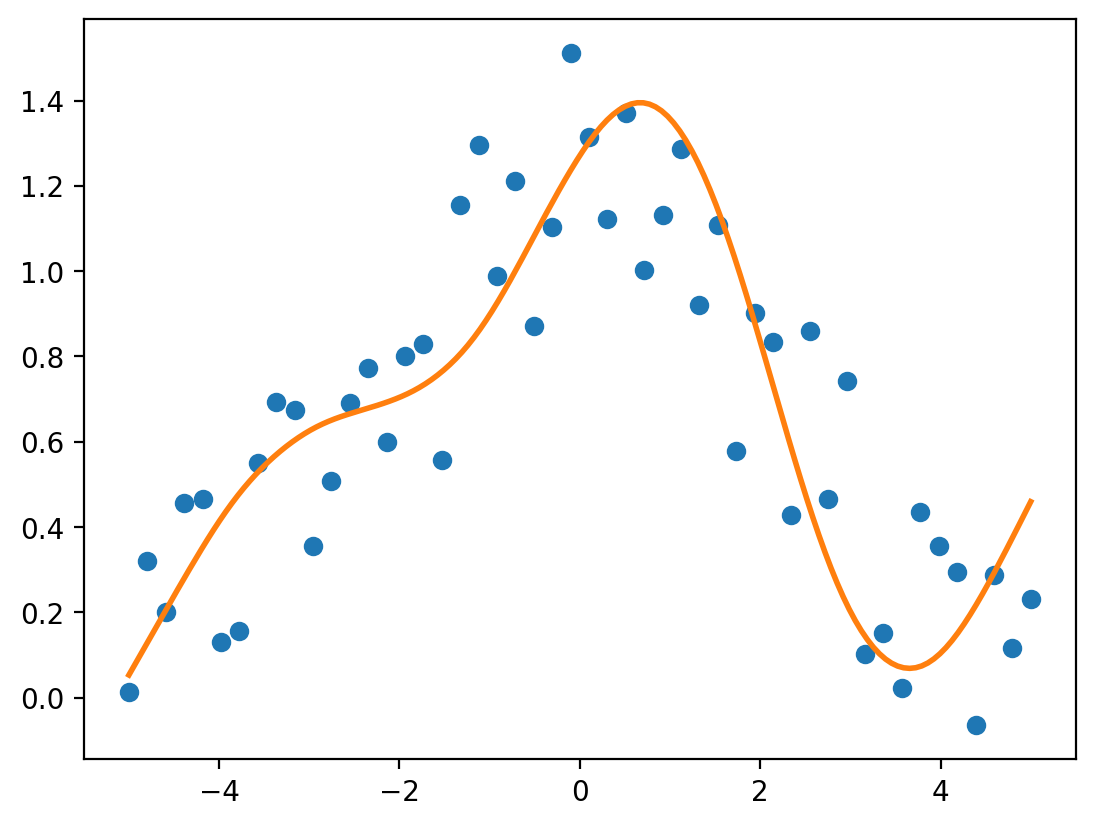

In [12]:
np.random.seed(1234)

x = np.linspace(-5., 5., 50)
y = np.exp(-(x/2.5)**2) + (np.random.rand(50) - 0.2) * 0.7

sp = cs.CubicSmoothingSpline(x, y, smooth=200)

xs = np.linspace(x[0], x[-1], 150)
ys = sp(xs)

plt.plot(x, y, 'o', xs, ys, '-',lw=2)
plt.show()

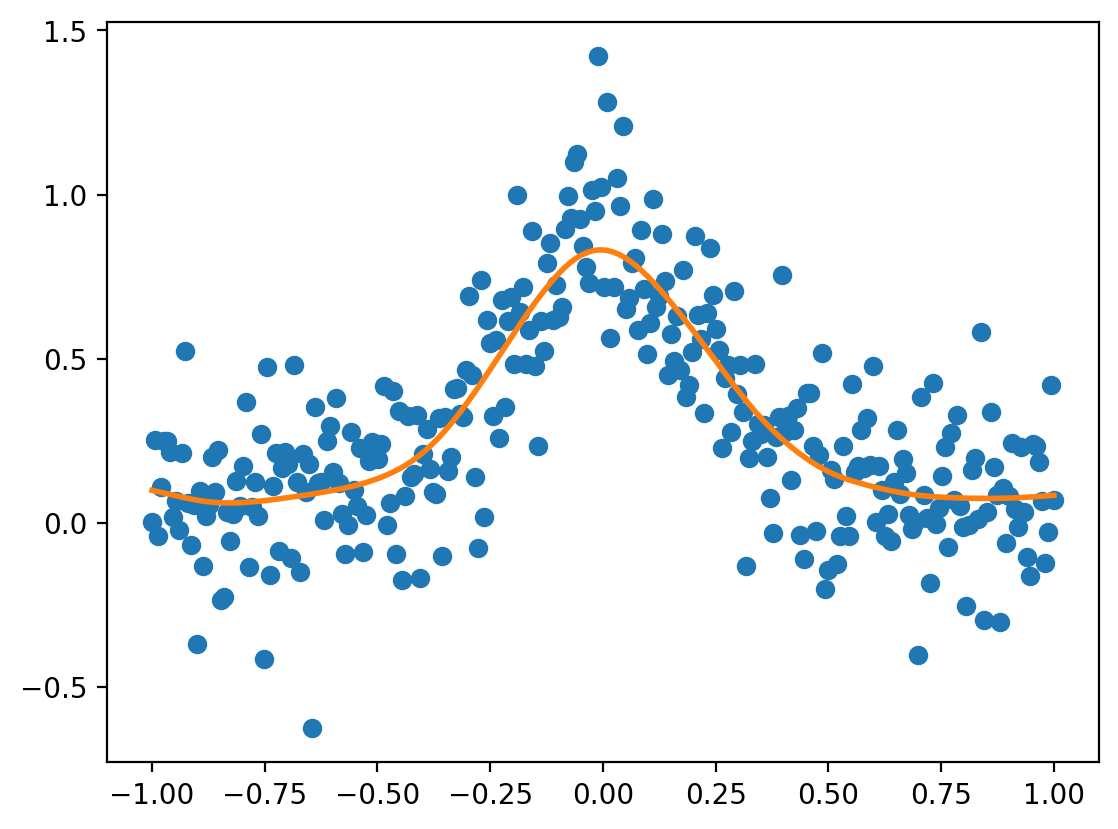

In [5]:
def func(x):
    return 1/(1+25*x**2)

# make example data
x = np.linspace(-1,1,300)
y = func(x) + np.random.normal(0, 0.2, len(x))

sp = cs.CubicSmoothingSpline(x, y, smooth=0.99)

xs = np.linspace(x[0], x[-1], 150)
ys = sp(xs)

plt.plot(x, y, 'o', xs, ys, '-',lw=2)
plt.show()

## Typically we need about $\sqrt{n}-4$ knots for the smoothing splines

In [ ]:
np.sqrt(200)-4

10.142135623730951

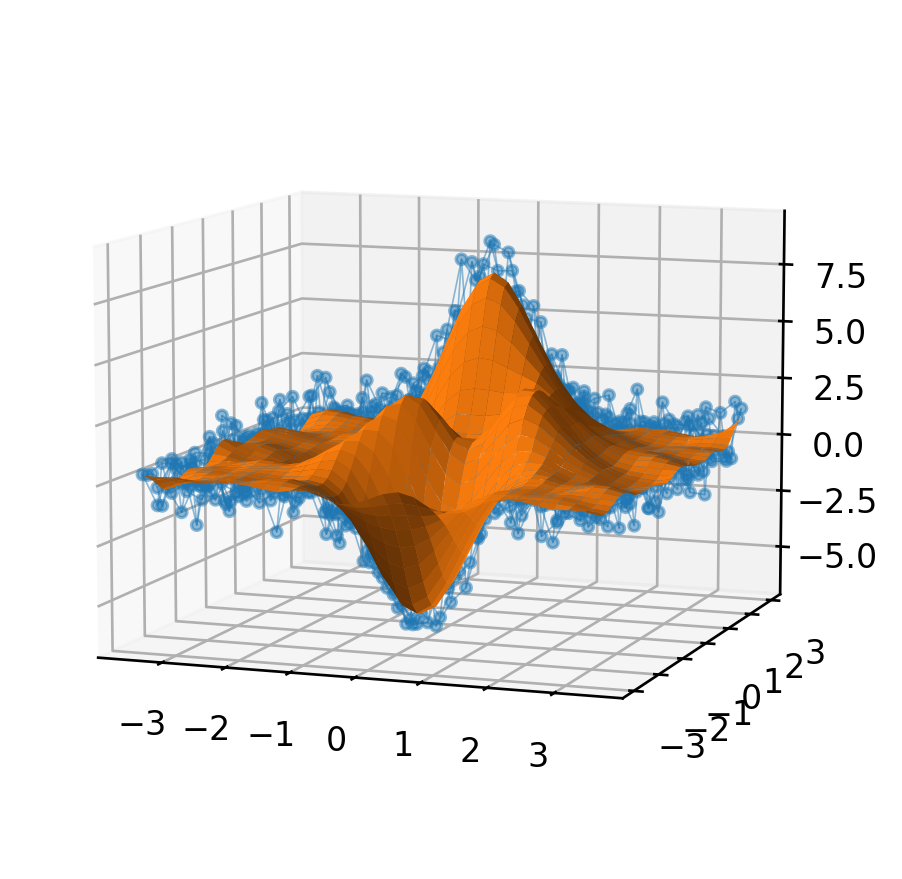

In [32]:

np.random.seed(1234)
xdata = [np.linspace(-3, 3, 41), np.linspace(-3.5, 3.5, 31)]
i, j = np.meshgrid(*xdata, indexing='ij')
ydata = (3 * (1 - j)**2. * np.exp(-(j**2) - (i + 1)**2)
         - 10 * (j / 5 - j**3 - i**5) * np.exp(-j**2 - i**2)
         - 1 / 3 * np.exp(-(j + 1)**2 - i**2))
ydata = ydata + (np.random.randn(*ydata.shape) * 0.75)

ydata_s = cs.csaps(xdata, ydata, xdata, smooth=0.988)

fig = plt.figure(figsize=(7, 4.5))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('none')
c = [s['color'] for s in plt.rcParams['axes.prop_cycle']]
ax.plot_wireframe(j, i, ydata, linewidths=0.5, color=c[0], alpha=0.5)
ax.scatter(j, i, ydata, s=10, c=c[0], alpha=0.5)
ax.plot_surface(j, i, ydata_s, color=c[1], linewidth=0, alpha=1.0)
ax.view_init(elev=9., azim=290)

plt.show()

## The Anatomy of Splines

Splines are third degree polynomial functions, such as

$$
s_i(x)=a_i(x-x_i)^3+b_i(x-x_i)^2+c_i(x-x_i)+d_i
$$

for $i=1,2,...,n-1$ and $x_i$ are the knots, values in the metric of the same feature. It is quite obvious that we have:
$$
s'_i(x) = 3a_i(x-x_i)^2+2b(x-x_i)+c_i
$$

and
$$
s''_i(x)=6a_i(x-x_i)+2b_i
$$


So we create

$$
S(x)=
\begin{cases}
s_1(x) &\text{if}& x_1\leq x < x_2 \\
s_2(x) &\text{if}& x_2\leq x < x_3 \\
...\\
s_n(x) &\text{if}& x_n-1\leq x < x_n
\end{cases}
$$

We generally want the following *properties* to hold:

1. $S(x)$ is continuous on $[x_1,x_n].$
2. $S'(x)$ is continuous on $[x_1,x_n].$
3. $S''(x)$ is continuous on $[x_1,x_n].$

And of course, we want to interpolate some data points:

$$
S(x_i)=y_i
$$

and that is to say that

$$
y_i= d_i.
$$

In order to make the curve smooth across the interval, the derivatives must be equal at the *stitching* points:

$$
s'_i(x_i) = s'_{i-1}(x_i).
$$

Let $M_i:=2b_i$ and $h=x_{i+1}-x_i$. After some tedious calculation we get the following matrix equation:


<figure>
<center>
<img src='https://i.imgur.com/6LL2RcQ.png'
width='700px' />
<figcaption>Relationship for the coefficients</figcaption></center>
</figure>

which linear system has $n-2$ rows and $n$ columns, so it is underdetermined. Imposing some extra conditions, we can solve the system.

One easy condition is $M_1=M_n=0$ and what we get is referred to as **Natural Splines**.

In [13]:
def get_natural_cubic_spline_model(x, y, minval=None, maxval=None, n_knots=None, knots=None):
    """
    Get a natural cubic spline model for the data.

    For the knots, give (a) `knots` (as an array) or (b) minval, maxval and n_knots.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.

    Parameters
    ----------
    x: np.array of float
        The input data
    y: np.array of float
        The outpur data
    minval: float
        Minimum of interval containing the knots.
    maxval: float
        Maximum of the interval containing the knots.
    n_knots: positive integer
        The number of knots to create.
    knots: array or list of floats
        The knots.

    Returns
    --------
    model: a model object
        The returned model will have following method:
        - predict(x):
            x is a numpy array. This will return the predicted y-values.
    """

    if knots:
        spline = NaturalCubicSpline(knots=knots)
    else:
        spline = NaturalCubicSpline(max=maxval, min=minval, n_knots=n_knots)

    p = Pipeline([
        ('nat_cubic', spline),
        ('regression', LinearRegression(fit_intercept=True))
    ])

    p.fit(x, y)

    return p


class AbstractSpline(BaseEstimator, TransformerMixin):
    """Base class for all spline basis expansions."""

    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None):
        if knots is None:
            if not n_knots:
                n_knots = self._compute_n_knots(n_params)
            knots = np.linspace(min, max, num=(n_knots + 2))[1:-1]
            max, min = np.max(knots), np.min(knots)
        self.knots = np.asarray(knots)

    @property
    def n_knots(self):
        return len(self.knots)

    def fit(self, *args, **kwargs):
        return self


class NaturalCubicSpline(AbstractSpline):
    """Apply a natural cubic basis expansion to an array.
    The features created with this basis expansion can be used to fit a
    piecewise cubic function under the constraint that the fitted curve is
    linear *outside* the range of the knots..  The fitted curve is continuously
    differentiable to the second order at all of the knots.
    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.
    Parameters
    ----------
    min: float
        Minimum of interval containing the knots.
    max: float
        Maximum of the interval containing the knots.
    n_knots: positive integer
        The number of knots to create.
    knots: array or list of floats
        The knots.
    """

    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = X.squeeze()
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError: # For arrays with only one element
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X.squeeze()

        def d(knot_idx, x):
            def ppart(t): return np.maximum(0, t)

            def cube(t): return t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                         - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X)).squeeze()
        return X_spl

Reference: https://stackoverflow.com/questions/51321100/python-natural-smoothing-splines

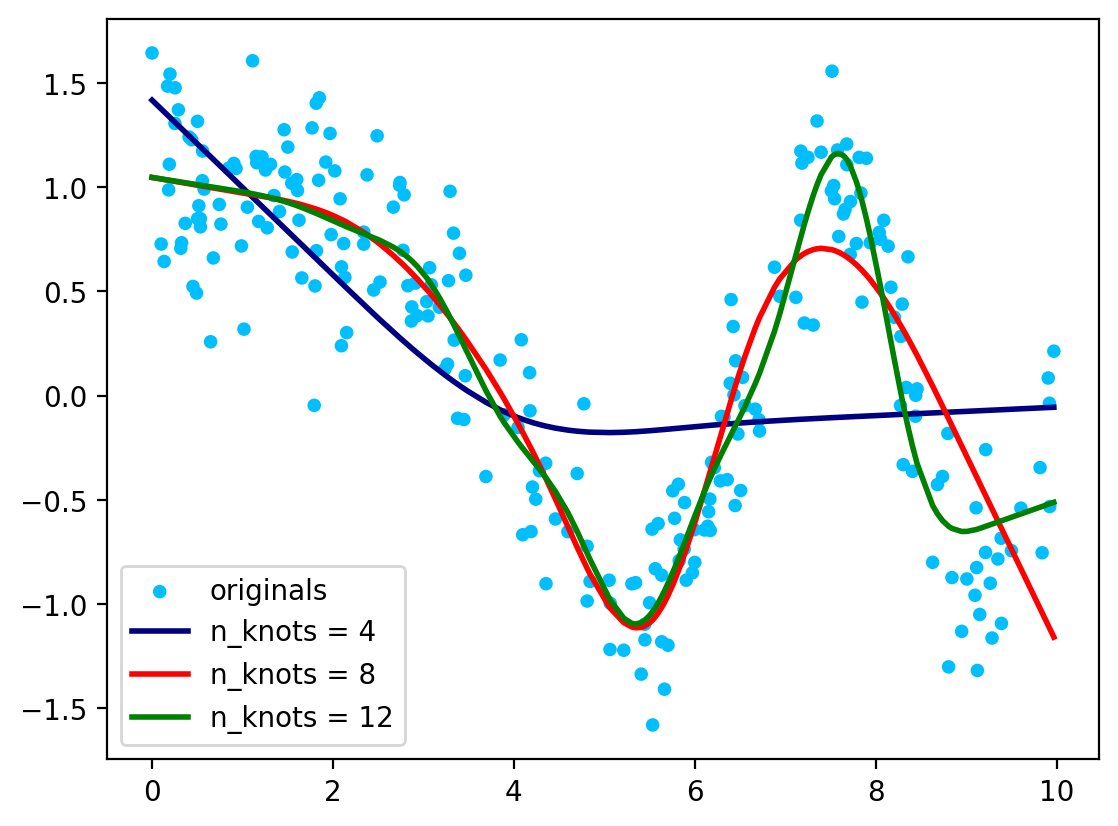

In [18]:
def func(x):
    return 1/(1+16*x**2)

# y = np.cos(-x**2/9.0)
# make example data
x = np.random.uniform(0,10,250)
x = x[np.argsort(x)]
y = np.cos(-x**2/9.0) + 0.3*np.random.normal(loc=0,scale=1,size=len(x))

# The number of knots can be used to control the amount of smoothness
model_4 = get_natural_cubic_spline_model(x, y, minval=min(x), maxval=max(x), n_knots=4)
model_8 = get_natural_cubic_spline_model(x, y, minval=min(x), maxval=max(x), n_knots=8)
model_12 = get_natural_cubic_spline_model(x, y, minval=min(x), maxval=max(x), n_knots=12)
y_est_4 = model_4.predict(x)
y_est_8 = model_8.predict(x)
y_est_12 = model_12.predict(x)

plt.scatter(x, y, ls='', marker='.', label='originals',s=60,color='deepskyblue')
plt.plot(x, y_est_4, label='n_knots = 4',lw=2,color='navy')
plt.plot(x, y_est_8, label='n_knots = 8',lw=2,color='red')
plt.plot(x, y_est_12, label='n_knots = 12',lw=2,color='green')
plt.legend();
plt.savefig('fig1.png',dpi=300)
plt.show()

## Message: the number of knots is a hyperparameter !!

## Real Data applications of the GAM

In [10]:
df = pd.read_csv('../Data Sets/housing.csv')
features = ['crime','rooms','residential','industrial','nox','older','distance','highway','tax','ptratio','lstat']
X = np.array(df[features])
y = np.array(df['cmedv']).reshape(-1,1)
Xdf = df[features]

In [11]:
Xdf

,crime,rooms,residential,industrial,nox,older,distance,highway,tax,ptratio,lstat
0,0.00632,6.575,18.0,2.31,0.538,65.199997,4.0900,1,296,15.300000,4.98
1,0.02731,6.421,0.0,7.07,0.469,78.900002,4.9671,2,242,17.799999,9.14
2,0.02729,7.185,0.0,7.07,0.469,61.099998,4.9671,2,242,17.799999,4.03
3,0.03237,6.998,0.0,2.18,0.458,45.799999,6.0622,3,222,18.700001,2.94
4,0.06905,7.147,0.0,2.18,0.458,54.200001,6.0622,3,222,18.700001,5.33
...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,6.593,0.0,11.93,0.573,69.099998,2.4786,1,273,21.000000,9.67
502,0.04527,6.120,0.0,11.93,0.573,76.699997,2.2875,1,273,21.000000,9.08
503,0.06076,6.976,0.0,11.93,0.573,91.000000,2.1675,1,273,21.000000,5.64
504,0.10959,6.794,0.0,11.93,0.573,89.300003,2.3889,1,273,21.000000,6.48


In [12]:
Xdf.shape

(506, 11)

In [13]:
from pygam import LinearGAM
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import KFold

In [14]:
scale = StandardScaler()
xtrain, xtest, ytrain, ytest = tts(X,y,test_size=0.3,random_state=1234)

In [15]:
xtrain = scale.fit_transform(xtrain)
Xtest =scale.transform(xtest)

In [16]:
gam = LinearGAM(n_splines=6).gridsearch(xtrain, ytrain,objective='GCV')
gam.summary()

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     46.3539
Link Function:                     IdentityLink Log Likelihood:                                  -1216.104
Number of Samples:                          354 AIC:                                             2526.9158
                                                AICc:                                            2541.8988
                                                GCV:                                               15.5594
                                                Scale:                                             11.9412
                                                Pseudo R-Squared:                                   0.8714
Feature Function                  Lam

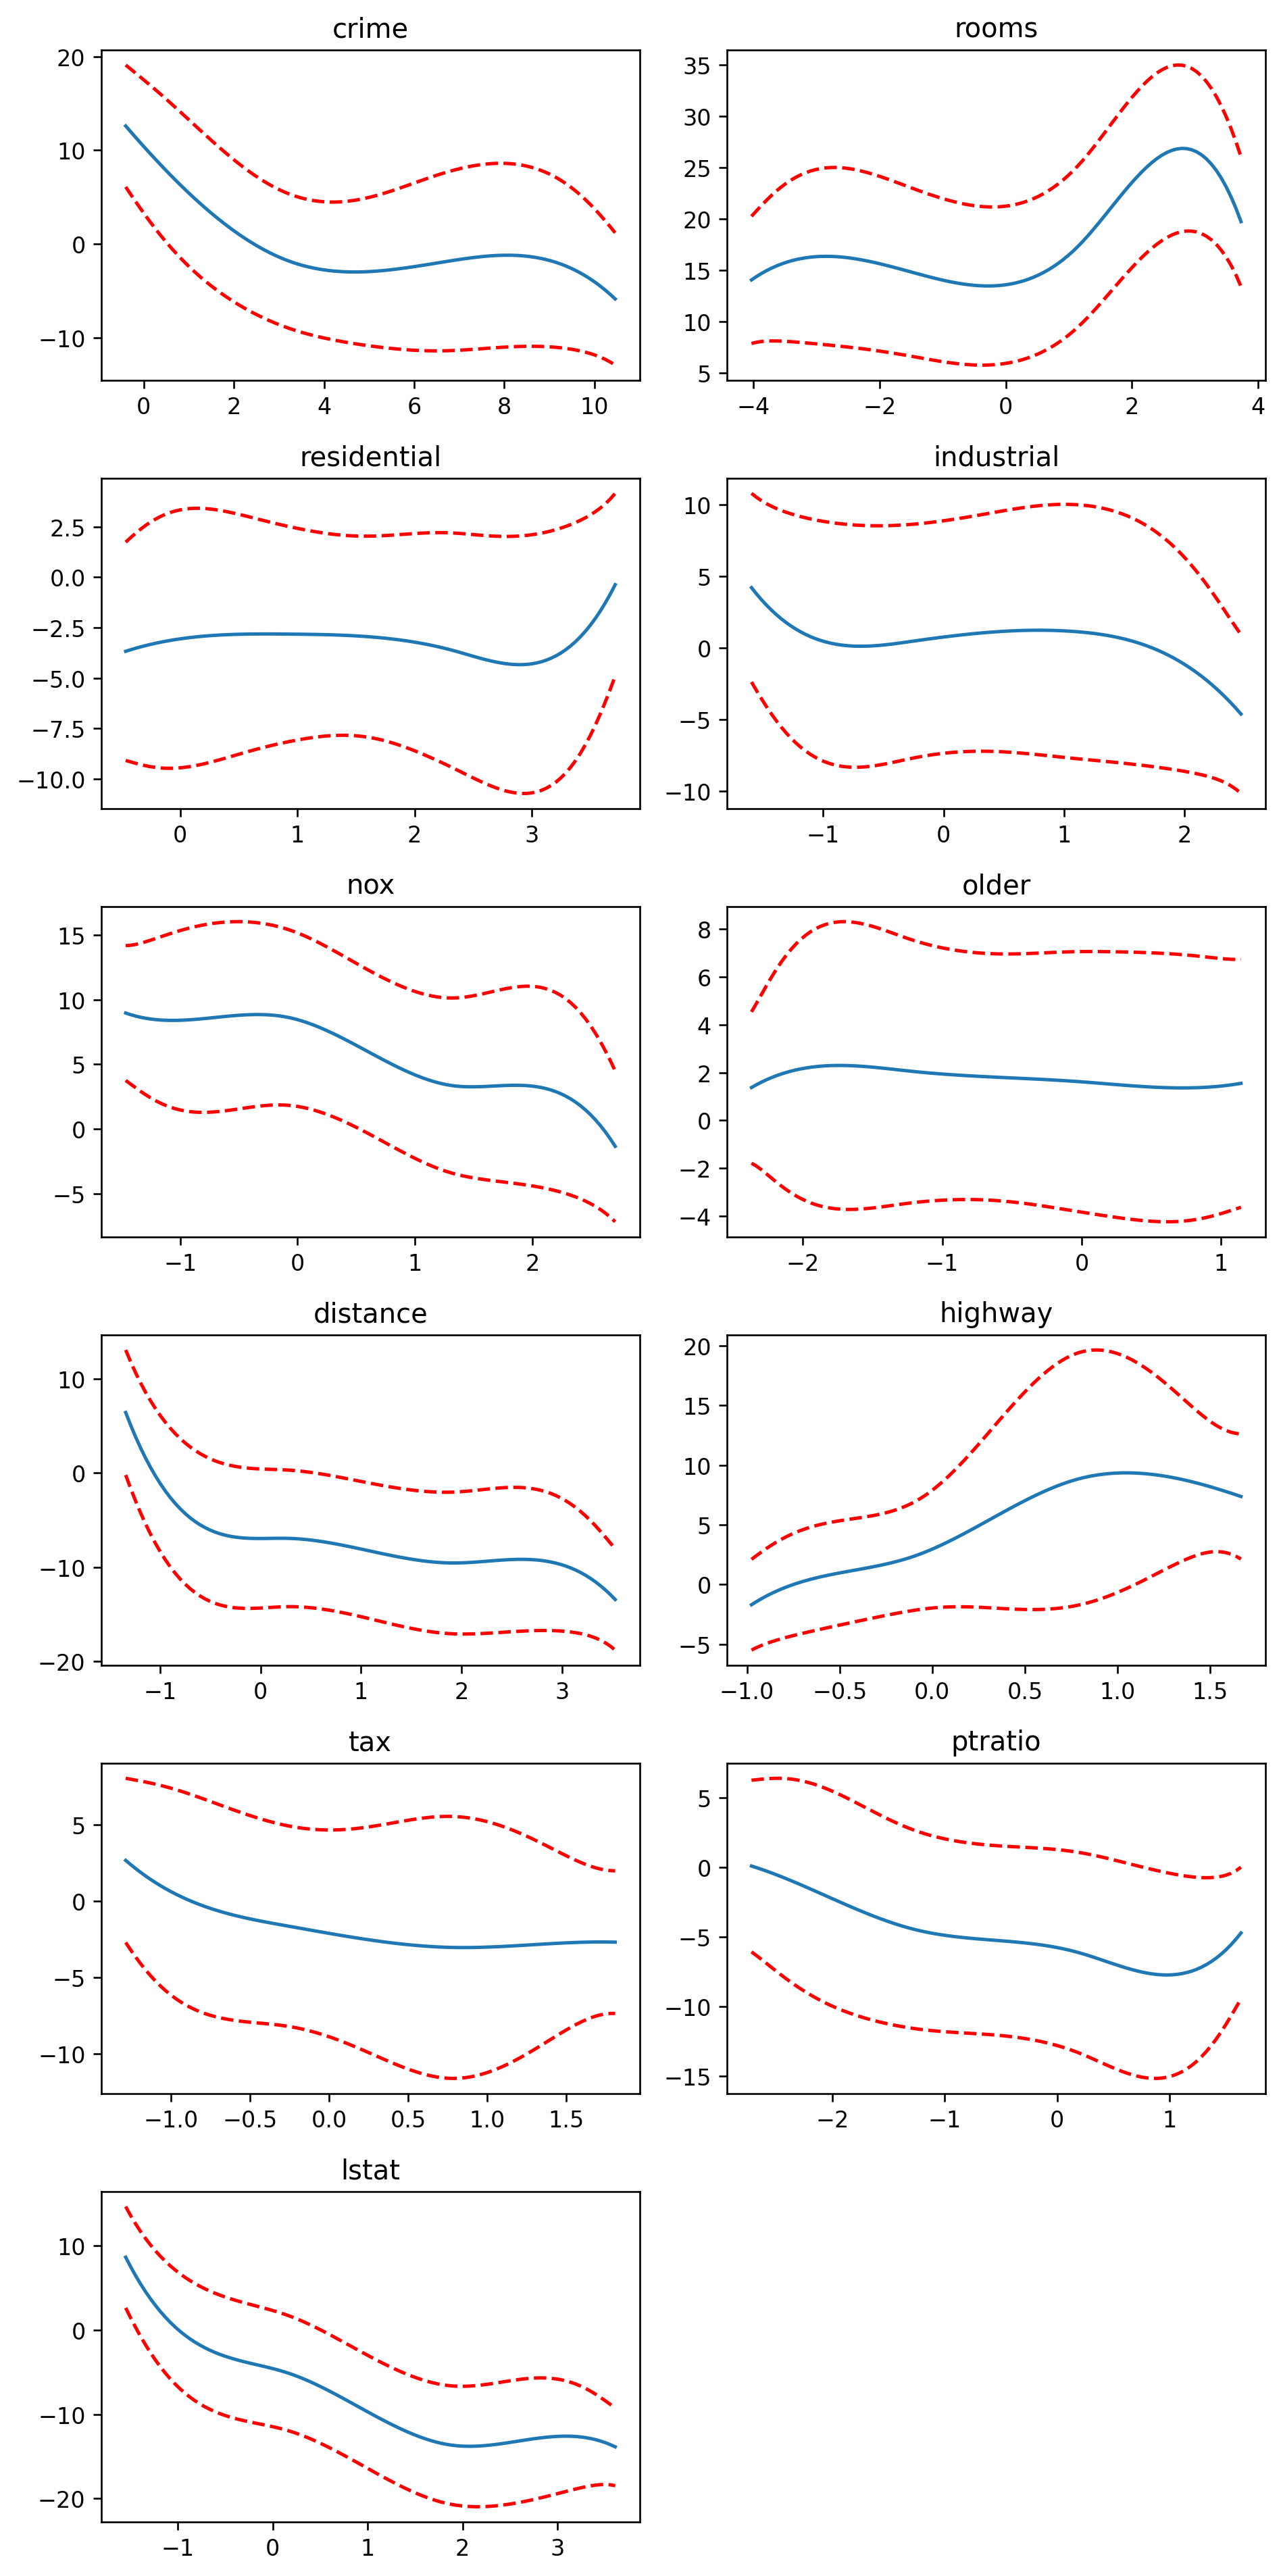

In [17]:
plt.rcParams['figure.figsize'] = (28, 8)
fig = plt.figure()
titles = df[features].columns

fig.set_figheight(16)
fig.set_figwidth(8)

for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    ax = fig.add_subplot(6, 2, i+1)
    ax.plot(XX[:, term.feature], pdep)
    ax.plot(XX[:, term.feature], confi, c='r', ls='--')
    ax.set_title(titles[i])
    fig.tight_layout()
plt.show()

In [ ]:
r2_score(ytrain,gam.predict(xtrain))

0.8713840976759943